# Homework 1: Named Entity Recognition (NER) with Sequence Labeling Models
## CS4740/5740 Fall 2022

### Milestone Submission Due: **September 15, 2022 (11:59 PM)** 

### Project Submission Due: **September 27, 2022 (11:59 PM)**

Should there be major updates to this document, we will announce them on [Ed Stem](https://edstem.org/us/courses/26793/discussion/).  Minor updates are documented on [this particular much-beloved thread](https://edstem.org/us/courses/26793/discussion/1739296).






**Names:**
Menglin Wang, Zhejun He
**Netids:**
mw976, zh254



**Editing your version of this notebook:** One partner should make a copy of this notebook and share it with your partner.  **However**, because of synchronization issues (even though Colab works with Google Drive), changes made in this notebook at the same time from different computers/browser windows may not save. We will go so far as to recommend that you close the tab with this notebook when you are not working on it so your partner doesn't face sync issues.



**Collaboration policy:** please be sure to check the collaboration policy on the [course website](https://courses.cs.cornell.edu/cs4740/2022fa/)!



> Assignment authors & testers: CS 4740/5740 professors and TAs from this and previous semesters, Chenxin Fang, Meghana Srivastava, Khonzoda Umarova, as well as Ruizhe Wang, Han Xia, and Heather Zhang.

# **Introduction**
---

In this project, you will tackle the **Named Entity Recognition** task: you'll implement models that identify named entities in text and tag them with the appropriate label. A primer on this task is provided further on.  We will treat this as a **sequence-tagging task**: for each token in the input text, assign one of the following 5 entity labels -- **ORG** (Organization), **PER** (Person), **LOC** (Location), **MISC** (Miscellaneous), and **O** (Not Named Entity) -- as well as a BIO-format prefix **B-** (token is the *beginning* of a named entity) or **I-** (token is *inside* a named entity). Overall, this yields 9 different labels: **B-ORG, I-ORG, B-PER, I-PER, B-LOC, I-LOC, B-MISC, I-MISC** and **O**.

For this project, you will implement two sequence labeling approaches:
- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM)/Logistic Regression classifier (also known as a MaxEnt classifier). Feature engineering is strongly suggested for this model!

A key component of both models is implementation of the Viterbi algorithm, which we will use to find the most likely tag sequence to assign to an input text.

## **Logistics**

---

- You are **strongly encouraged** to work in **groups of 2 students**. Students in the same group will get the same grade. Thus, you should make sure that everyone in your group contributes to the project. 
- **Do not form teams of two on Kaggle** (You *will* form teams on a different platform; details TBA) because submitting separately gives you more tries, which is useful when experimenting with different models. 
- **Before submitting your predictions on Kaggle**, please rename your "Kaggle team" (since you and your partner are not forming your group on the Kaggle platform, this "team" would actually only include you) to be your NetID (eg: `team_ku47`). You can do so under `Team` tab of the competition. 
- A part of your submission would involve uploading your notebook (details would be provided soon!). So, please enter all code and answer all the questions in this colab notebook.
  - Your code must have docstrings/comments documenting the meaning of parameters and important parameter-like variables.
- In this assignment you are asked to make two submissions:
  1. Intermediate **milestone submission due on 9/15/22 (11:59 PM)**. For this, please 1) have your teams formed (mechanism TBA) and  2) submit predictions of your first model (HMM) on Kaggle. This means that you should aim to complete Part 1 and Part 2 of the assignment by this milestone. Points will be awarded for meeting the milestone deadline, but we will only grade for completion, not correctness. 
  2. The **final homework submission due on 9/27/22 (11:59 PM)**. (details TBA)
- Please be sure to consult the [list](https://docs.google.com/document/d/1-QmpkZYJDCM4gQQ9sZW2EwD5ltYy1CFjlJTbhD0Be-A/edit?usp=sharing) of banned packages/libraries before you start implementing your models. Note that this list may get updated.



## **Advice**

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. An assignment outline and grading breakdown (subject to minor adjustments) is found below; please consult it.
3. The project is somewhat open ended. We will ask you to implement the models, but in some cases precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using the given evaluation code (more instructions later).

<a name="outline"></a>
## **Assignment outline and grading breakdown**
- [Part 1](#part1)
  - [Q1](#q1) [10 pts]
- [Part 2](#part2)
  - [Unknown Word Handling](#unknowns_handling) [15 pts]
  - [HMM Implementation](#hmm_implementation) [20 pts]
  - [Viterbi Implementation](#viterbi_implementation) [20 pts]
  - [Validation](#validation_data) [3 pts]
  - [Q2.1](#q2.1) [5 pts]
  - [Q2.2](#q2.2) [5 pts]
  - [Q2.3](#q2.3) [5 pts]
  - [Q2.4](#q2.4) [5 pts]
- [Part 3](#part3)
  - [Features](#features) [35 pts]
  - [MEMM Implementation](#memm_implementation) [25 pts]
  - [Q3.1](#q3.1) [5 pts]
  - [Q3.2](#q3.2) [5 pts]
  - [Q3.3](#q3.3) [5 pts]
  - [Q3.4](#q3.4) [5 pts]
- [Part 4](#part4)
  - [Q4.1](#q4.1) [7 pts]
  - [Q4.2](#q4.2) [7 pts]
  - [Q4.3](#q4.3) [7 pts]
- [Part 5](#part5)
  - [Q5](#q5)


Meeting the milestone deadline [10 pts];

Outperforming our baseline on Kaggle [15 pts];



## **Named Entity Recognition: Review**

---

NER refers to the information extraction technique of identifying and categorizing key information about entities within textual data. NER is important for:
  - Detecting entities in search engines and voice assistants for more relavent search results.
  - Automatically parsing resumes.
  - ...and much more!

In our dataset named entity tags are formatted in BIO/IOB format. With this format, entity tags get a prefix. Prefix "B-" is added to the first word/token of the entity name. All following tokens that are part of the same entity name would get prefix "I-". 

Here is an example sentence: "ZIFA
said
Renate
Geotschel
of
Austria
won the women's World Cup  downhill race in Germany."
Entity "Renate Goetschl" gets "Renate" (B-PER) and "Goestchl" (I-PER). Similarly, for "World Cup" we'd have "World" (B-MISC) and "Cup" (I-MISC). If an entity only has one token, then its entity tag would still have prefix "B-". "O" is used to denote tokens that are not part of any named entity. Thus, from the example above, we'd have:

```"ZIFA" B-ORG```

 ```"said" O```

 ```"Renate" B-PER```

 ```"Goetschl" I-PER```

 ```"of" O```

 ```"Austria" B-LOC```

 ```"won" O```

 ```"the" O```

 ```"women's" O```

 ```"World" B-MISC```

 ```"Cup" I-MISC```

 ```"downhill" O```

 ```"race" O```

 ```"in" O```

 ```"Germany" B-LOC```


Although NER is predominantly handled by deep learning approaches, for now let's use HMMs and MEMMs. 


To read more on NER, we refer to any of the following sources:
1. Medium post [1](https://umagunturi789.medium.com/everything-you-need-to-know-about-named-entity-recognition-2a136f38c08f) and [2](https://medium.com/mysuperai/what-is-named-entity-recognition-ner-and-how-can-i-use-it-2b68cf6f545d).
2. Try out [this](https://demo.allennlp.org/named-entity-recognition/named-entity-recognition) AlllenNLP demo! Please note that this demo uses a slightly different format of NER tags.

## **Evaluation: Entity Level Mean F1**

---

The standard evaluation measures to report for NER are recall, precision, and F1 score
(also called F-measure) evaluated at the **named entity level** (not at the token level). The code for this has been provided later under the validation section under Part 2. Please use this code when evaluating your models. 


If P and T are the sets of predicted and true *named entity spans*, respectively, (e.g, the five named entity spans in the above example are "Zifa", "Renate Goetschl", "Austria", "World Cup", and "Germany") then

####<center>Precision = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{P}|}$ and Recall = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{T}|}$.</center><br/>


####<center>F1 = $\frac{2 * \text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$. </center><br/>

For each type of named entity, e.g. *LOC*ation, *MISC*ellaneous, *ORG*anization and *PER*son, we calculate the F1 score as shown above, and take the mean of all these F1 scores to get the **Entity Level Mean F1** score for the test set. If $N$ is the total number of labels (i.e., named entity types), then

####<center>Entity Level Mean F1 = $\frac{\sum_{i = 1}^{N} \text{F1}_{{label}_i}}{N}$. </center>

More details under the validation section in Part 2.



<a name="part1"></a>
# **Part 1: Dataset**
[[^^^]](#outline) 

Our data is a modified version of the WikiNEuRal ([ Tedeschi et al.](https://aclanthology.org/2021.findings-emnlp.215.pdf)) dataset.

Load the dataset as follows:
  1. Obtain the data from Data tab of the [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957).
  2. Unzip the data. Put it into your Google Drive, run the cells below to mount it to Colab:


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import json

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(), "drive", "MyDrive")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

Here's a few things to note about the dataset above:
1. We have loaded 3 `.json` files: for training, validation, and testing.
2. The train and validation files contain the following 3 fields (each is a nested list): 
  - **'text'** - actual input tokens
  - **'NER'** - the token-level entity tag 
  - **'index'** - index of the token in the dataset
3. The test data only has **'text'**, and **'index'** fields. You will need to submit your prediction of the **'NER'** tag to Kaggle.


### **Q1: Initial Data Observations**

In the space below please add your code for dataset explorations for Q1.

In [ ]:
import pandas as pd
train_data = pd.DataFrame({'text':train['text'],'index':train['index'],'NER':train['NER']})
test_data = pd.DataFrame({'text':test['text'],'index':test['index'],'NER':val['NER']})
val_data = pd.DataFrame({'text':val['text'],'index':val['index'],'NER':val['NER']})

In [ ]:
train_data.head()

,text,index,NER
0,"[Because, of, its, high, rate, of, economic, m...","[94033, 94034, 94035, 94036, 94037, 94038, 940...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-LOC,..."
1,"[Every, aspect, of, life, was, regulated, to, ...","[1805713, 1805714, 1805715, 1805716, 1805717, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[Yet, despite, his, impending, death, ,, Louis...","[839361, 839362, 839363, 839364, 839365, 83936...","[O, O, O, O, O, O, B-PER, O, O, O, O, O]"
3,"[Direct, fluorescent, antibody, can, also, be,...","[1042749, 1042750, 1042751, 1042752, 1042753, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[It, has, yet, to, be, released, on, CD, ,, th...","[464713, 464714, 464715, 464716, 464717, 46471...","[O, O, O, O, O, O, O, O, O, O, O, B-ORG, O, O,..."


In [ ]:
train_data.describe()

,text,index,NER
count,7000,7000,7000
unique,7000,7000,5368
top,"[Because, of, its, high, rate, of, economic, m...","[94033, 94034, 94035, 94036, 94037, 94038, 940...","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O]"
freq,1,1,18


In [ ]:
val_data.describe()

,text,index,NER
count,400,400,400
unique,400,400,390
top,"[They, had, met, during, a, softball, game, fo...","[57004, 57005, 57006, 57007, 57008, 57009, 570...","[O, O, O, O, O, B-PER, I-PER, O]"
freq,1,1,4


In [ ]:
test_data.describe()

,text,index,NER
count,400,400,400
unique,400,400,390
top,"[The, Yankees, won, the, series, in, five, gam...","[146976, 146977, 146978, 146979, 146980, 14698...","[O, O, O, O, O, B-PER, I-PER, O]"
freq,1,1,4


the longest document length is  131
the shortest document length is  2


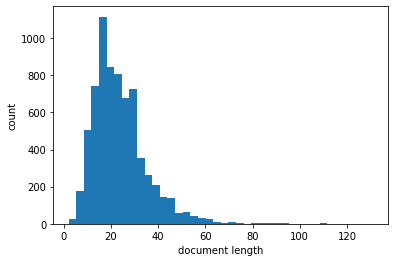

In [ ]:
# document lengths
import numpy as np
document= np.asarray(train_data['text'])

la= []
for i in range(document.size):
  la.append(np.asarray(document[i]).size)
import matplotlib.pyplot as plt
print("the longest document length is ",max(la))
print("the shortest document length is ",min(la))
plt.hist(la, bins= 40)
plt.xlabel("document length")
plt.ylabel("count")
plt.show()

In [ ]:
token_class = {}
entity_class = {}
for label in train_data['NER']:
  for l in label:
    token_class[l] = token_class.get(l,0)+1
    if len(l)>1:
      ls = l.split('-')[1]
      entity_class[ls] = entity_class.get(ls,0)+1

{'O': 147113,
 'B-LOC': 4060,
 'B-PER': 3016,
 'I-PER': 2217,
 'B-ORG': 1725,
 'B-MISC': 2815,
 'I-LOC': 1451,
 'I-MISC': 2566,
 'I-ORG': 1431}

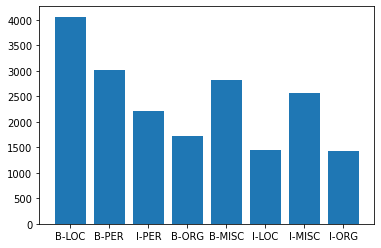

In [ ]:
plt.bar(list(token_class.keys())[1:], list(token_class.values())[1:])
token_class

<BarContainer object of 4 artists>

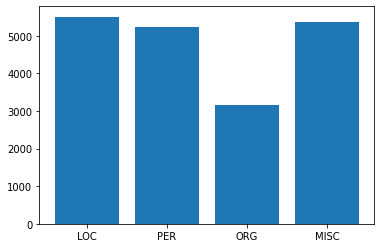

In [ ]:
plt.bar(entity_class.keys(), entity_class.values())

In [ ]:
for i in range(3):
  s= ""
  s1= train_data['text'][i]
  s2= train_data['NER'][i]
  for idx, word in enumerate(s1):
    if(len(s2[idx])>1):
      s+= '['+s2[idx]+' '+word+']'+' '
    else:
      s+=word+' '
  print(s)

Because of its high rate of economic marginalization , more people migrate from [B-LOC Chiapas] than migrate to it . 
Every aspect of life was regulated to some degree by the party , and the will of its founding-president , [B-PER Mobutu] [I-PER Sese] [I-PER Seko] . 
Yet despite his impending death , [B-PER Louis] 's mind remained clear . 


<a name="q1"></a>
[[^^^]](#outline) 

What are your initial observations after you explore the dataset?  Provide some quantitative data exploration. Assess dataset size, document lengths and the token-level NER class distribution, and the entity-level NER class distribution (skipping the 'O' label for the latter). Give some examples of sentences with their named entities bracketed, e.g. [[B-LOC Romania] state budget soars in June .] and [[B-ORG Zifa] said [B-PER Renate] [I-PER Goetschl] of [B-LOC Austria]...]. 


#### **A1:**

As we explored the dataset, we made some observations:

1. The train dataset has 7000 entries, test dataset has 400 entries and validation set has 400 entries
2. The longest document length is 131, versus the shortest document length is 2, and the most common lengths are located between 10 - 20.
3. The token-level NER class distribution, and the entity-level NER class distribution has shown above via bar chart, they both distributed well
4. Eg words: 
  - Because of its high rate of economic marginalization , more people migrate from [B-LOC Chiapas] than migrate to it . 
  - Every aspect of life was regulated to some degree by the party , and the will of its founding-president , [B-PER Mobutu] [I-PER Sese] [I-PER Seko] . 
  - Yet despite his impending death , [B-PER Louis] 's mind remained clear . 

<a name="part2"></a>
# **Part 2: Hidden Markov Model**
[[^^^]](#outline) 
---
In this part of the assignment, you will:
1. Implement code for counting and smoothing of labels and words, as well as unkown word handing, as necessary to support the Viterbi algorithm. 
2. Build a Hidden Markov Model in accordance with the provided function headers. **You may NOT change the function specifications.** Please ensure that your code is clear, concise, and, most important of all, modular. This means you should break your implementation down into smaller functions or write it within a class. Please compute all probabilities in natural log when building the HMM.
3. Implement the **Viterbi algorithm**, that can be used to infer token-level labels (identifying the appropriate named entity) for an input document. This process is commonly referred to as **decoding**. Bigram-based Viterbi is $ \mathcal{O}(sm^2)$ where *s* is the length of the sentence and *m* is the number of tags. Your implementation should have similar efficiency. The code for this can be used later on for the MEMM too.

### References
You may find chapters [3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) and [8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, section 3.4.1 covers ways to handle unknown words, and section 3.5 goes over smoothing. 

<a name="unknowns_handling"></a>
## **Unknown Word Handling**
[[^^^]](#outline) 
---

In [ ]:
# Implement unknown word handling here! You may do this any way that you please

# handling unkown words

words= {}
for s in train_data['text']:
  s1= s
  for idx, word in enumerate(s1):
    words[word]= words.get(word, 0) +1

threshold= 1

token_new= []
r=0
for s in train_data['text']:
  l2=[]
  for i in s:
    if words[i] <= threshold and len(i) > 12:
      r+=1
      l2.append("<UNK>")
    else:
      l2.append(i)  
  token_new.append(l2)  


print("The number that set of unknown word is", r)
print("the size of Vocabulary:",len(words))


The number that set of unknown word is 889
the size of Vocabulary: 24823


In [ ]:
words_new= {}
for i in range(len(token_new)):
  for j in range(len(token_new[i])):
    if(token_new[i][j] == "<UNK>"):
      words_new[train_data['NER'][i][j]]= words_new.get(train_data['NER'][i][j], 0) +1

<a name="hmm_implementation"></a>
## **HMM Implementation**
[[^^^]](#outline) 
---

In the skeleton code below, we have broken down the HMM into its three components: the transition matrix, the emission matrix, and the start state probabilities. We suggest you implement them separately and then use them to build the HMM.


In [ ]:
import math
# Returns the transition probabilities.
def build_transition_matrix(labels, k=0):
  """
    Returns a dictionary that has tuples of every label bigram as keys, and
    the associated value being the respective transition probabilities (in 
    natural log).
    Eg. {("O", "B-ORG"): -9.98690147425591, 
         ("B-LOC", "I-LOC"): -3.69537214,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  labels_new=[]
  for i in labels:
    l=[]
    for j in i:
      l.append(j)
    l.append("<end>")
    labels_new.append(l)  

  label_map= {}
  for la in labels_new:
    for l in la:
      label_map[l]= label_map.get(l, 0)+1
  label_list= list(label_map.keys())

  res={}

  for l in label_list:
    for t in label_list:
      res[(l,t)]= res.get((l,t), 0) +k # smoothing

  for i in range(len(labels_new)):
    for j in range(len(labels_new[i])):
      if j>0 :
        l= labels_new[i][j-1]
        t= labels_new[i][j]
        res[(l,t)]= res.get((l,t))+1
  for l in label_list:
    for t in label_list:
      res[(l,t)]= math.log10(res.get((l,t))/ (label_map.get(l) +(len(label_list)* k)))
  return res


In [ ]:
# Returns the emission probabilities.
import math
def build_emission_matrix(tokens, labels, k=0):
  """
    Returns a dictionary that has label-token tuples as keys, and emission 
    probabilities (in natural log) for each respective label-token pair as values.  

    Eg. {("O", "Because"): -10.133904545421267, 
         ("I-PER", "Markov"): -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter tokens: A list where each element represents a sentence, 
    and each sentence is a list of its tokens. (Eg. [['The', 'most', 
    'significant', 'damage', 'was', 'on', 'Tortola', '.'], [...], ...])
    :type tokens: List[List[String]]
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  token_map= {}
  label_map= {}
  for la in labels:
    for l in la:
      label_map[l]= label_map.get(l, 0)+1
  for token in tokens:
    for t in token:
      token_map[t]= token_map.get(t, 0)+1
  label_list= list(label_map.keys())
  token_list= list(token_map.keys())

  res={}
  for l in label_list:
    for t in token_list:
      res[(l,t)]= res.get((l,t), 0) +k # smoothing

  for i in range(len(labels)):
    for j in range(len(labels[i])):
      l= labels[i][j]
      t= tokens[i][j]
      res[(l,t)]= res.get((l,t))+1

  for l in label_list:
    for t in token_list:
      res[(l,t)]= math.log10(res.get((l,t))/ ((len(token_list) * k) + label_map.get(l)))
  return res
  

In [ ]:
# Returns the starting state probabilities.
def get_start_state_probs(labels, k=0):
  """
    Returns a dictionary that has labels for keys, and the respective state 
    probabilities (in natural log) for values.  

    Eg. {"O": -10.133904545421267, 
         "I-PER": -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
  label_map= {}
  for la in labels:
    for l in la:
      label_map[l]= label_map.get(l, 0)+1
  label_list= list(label_map.keys())

  res= {}
  for l in label_list:
    res[l]= res.get(l, 0)+k
  for i in range(len(labels)):
    res[labels[i][0]]= res.get(labels[i][0],0)+1

  for l in label_list:
    res[l]= math.log10(res.get(l)/ (len(labels)+ (k*len(label_list))))

  return res

In [ ]:
get_start_state_probs(train['NER'], k=0.1)

{'O': -0.038831420800450184,
 'B-LOC': -1.6221774243935554,
 'B-PER': -1.4025173485047149,
 'I-PER': -4.845153874286947,
 'B-ORG': -1.9812364973290861,
 'B-MISC': -1.9361330200757907,
 'I-LOC': -4.845153874286947,
 'I-MISC': -4.845153874286947,
 'I-ORG': -4.845153874286947}

In [ ]:
# Takes in the tokens & labels and returns a representation of the HMM.
# Call the three functions above in this function to build your HMM.
def build_hmm(tokens, labels):
  res = {}
  res["transition"] = build_transition_matrix(labels, k=1)
  res["emission"] = build_emission_matrix(tokens, labels, k=0.01)
  res["start"] = get_start_state_probs(labels, k=1)
  label_map= {}
  for la in labels:
    for l in la:
      label_map[l]= label_map.get(l, 0)+1
  res["labels"] = list(label_map.keys())
  token_map= {}
  for to in tokens:
    for t in to:
      token_map[t]= token_map.get(t, 0) +1
  res["tokens"]= list(token_map.keys())
  return res

<a name="viterbi_implementation"></a>
## **Viterbi Implementation**
[[^^^]](#outline) 
---

At the end of your implementation, we expect a function or class that maps a sequence of tokens (observation) to a sequence of labels via the Viterbi algorithm.

In [ ]:
import sys
# Takes in the HMM built above and an observation (i.e. a list of tokens),
# and returns a list with predicted named entity mappings for the tokens.
# The returned list should be the same length as the input obeservation.
def viterbi(hmm, observation):
  start_probs = hmm["start"]
  emission_probs = hmm["emission"]
  transition_probs = hmm["transition"]
  labels_list = hmm["labels"]
  tokens_list= hmm["tokens"]
  token_set= set(tokens_list)
  for i in range(len(observation)):
    if observation[i] not in token_set:
      observation[i]= "<UNK>"

  backpointer= [[0]*len(observation) for i in range(len(labels_list))] # [label][obser]
  dp= [[0]*len(observation) for i in range(len(labels_list))]
  for i in range(len(labels_list)):
    dp[i][0]= start_probs[labels_list[i]] + emission_probs[(labels_list[i], observation[0])]
  
  for i in range(1, len(observation)):
    pointer=-sys.maxsize - 1
    for j in range(len(labels_list)):
      m= -sys.maxsize - 1
      for k in range(len(labels_list)):
        cur= dp[k][i-1] + transition_probs[(labels_list[k], labels_list[j])] + emission_probs[(labels_list[j], observation[i])] 
        if cur > m:
          m= cur
          backpointer[j][i]= k
      dp[j][i]= m  
  m= -sys.maxsize - 1
  idx= -1
  for i in range(len(labels_list)):
    cur= dp[i][len(observation)-1] + transition_probs[(labels_list[i], '<end>')]
    if cur > m:
      m= cur
      idx= i
  res=[]
  res.append(labels_list[idx])
  for j in range(len(observation)-1, 0, -1):
    #print(backpointer[idx][j])
    idx= backpointer[idx][j]
    res.append(labels_list[idx])
  res.reverse()
  return res


In [ ]:
# Here's a sample observation that you can use to test your code
#obs_1 =["Mobutu", "Sese", "Seko", ".","Yet", "despite", "his", "impending", "death" , ",", "Louis","'s", "mind", "remained", "clear"] 
# Yet despite his impending death , [B-PER Louis] 's mind remained clear . 
#[B-PER Mobutu] [I-PER Sese] [I-PER Seko] .  Yet despite his impending death , [B-PER Louis] 's mind remained clear . 
obs_1 = ['A',
 'spokesman',
 'for',
 'Cornell',
 'University',
 'said']

# Uncomment and fill out the following line to test your implementation:
hmm = build_hmm(token_new, train_data['NER'])
a=viterbi(build_hmm(token_new, train_data['NER']),obs_1)
a

['O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']

## **Validation Step**
<a name="validation_data"></a>
[[^^^]](#outline) 
---

In this part of the project, we expect you to train your HMM model (i.e., get transition and emission probabilities) on the labeled training data and evaluate it on the validation data. Report **Entity Level Mean F1**, which was explained earlier. Please use the code we have provided below to compute this metric.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generation) probabilities.

Consider the example below. After getting a sequence of NER labels for the sequence of tokens from your Viterbi algorithm implementation, you need to convert the sequence of tokens, associated token indices and NER labels into a format which can be used to calculate **Entity Level Mean F1**. We do this by finding the starting and ending indices of the spans representing each entity (as given in the corpus) and adding it to a list that is associated with the label with which the spans are labelled. To score your validation data on Google Colab or your local device, you can get a dictionary from the function **format_output_labels** on both the predicted and true label sequences, and use the two dictionaries as input to the **mean_f1** function.

NOTE: We do **not** include the spans of the tokens labelled as "O" in the formatted dictionary output.

In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (LOC, ORG, MISC or PER) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    Eg. if [token_labels] = ["B-ORG", "I-ORG", "O", "O", "B-ORG"]
           [token_indices] = [15, 16, 17, 18, 19]
        then dictionary returned is 
        {'LOC': [], 'MISC': [], 'ORG': [(15, 16), (19, 19)], 'PER': []}

    :parameter token_labels: A list of token labels (eg. B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, OR I-MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"LOC":[], "MISC":[], "ORG":[], "PER":[]}
    prev_label = 'O'
    entity_label = ''
    start_idx = 0
    ll = len(token_labels)
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith("B"):
        start_idx = token_indices[idx]
        entity_label = curr_label
      if label == 'O' and prev_label != "O":
        label_dict[entity_label].append((start_idx, token_indices[idx-1]))
      if label.startswith('I') and prev_label == 'O':
        start_idx = token_indices[idx]
        entity_label = curr_label
      if (label.startswith('B') or label.startswith('I')) and idx+1 == ll:
        label_dict[entity_label].append((start_idx, token_indices[idx]))
      prev_label = label[0]
    return label_dict

    # for idx, label in enumerate(token_labels):
    #   curr_label = label.split('-')[-1]
    #   if label.startswith("B-") or (curr_label != prev_label and curr_label != "O"):
    #     if prev_label != "O":
    #         label_dict[prev_label].append((start, token_indices[idx-1]))
    #     start = token_indices[idx]
    #   elif label == "O" and prev_label != "O":
    #     label_dict[prev_label].append((start, token_indices[idx-1]))
    #     start = None

    #   prev_label = curr_label
    # if start is not None:
    #   label_dict[prev_label].append((start, token_indices[idx-1]))
    # return label_dict

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [ ]:
# Usage using above example
#'<UNK>', 'University', 'is', 'located', 'in', 'Ithaca', 'and', 'was', 'founded', 'by', 'Ezra', 'Cornell'
pred_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "O", "O", "O", "O", "B-LOC"]
true_token_labels = ["B-ORG", "O", "B-PER", "I-PER", "O", "B-LOC", "O", "O", "O", "O", "B-MISC", "I-MISC", "O", "O", "O", "B-LOC"]
token_indices = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

y_pred_dict = format_output_labels(pred_token_labels, token_indices)
print("y_pred_dict is : " + str(y_pred_dict))
y_true_dict = format_output_labels(true_token_labels, token_indices)
print("y_true_dict is : " + str(y_true_dict))

print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))

y_pred_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 23)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
y_true_dict is : {'LOC': [(18, 18), (28, 28)], 'MISC': [(23, 24)], 'ORG': [(13, 13)], 'PER': [(15, 16)]}
Entity Level Mean F1 score is : 0.75


In [ ]:
# Evaluate/validate your model here
pred_token_labels_ll = []
true_token_labels_ll = []
token_indices = []
for i in range(len(val_data['text'])):
  pred_token_labels = viterbi(hmm, val_data['text'][i])
  pred_token_labels_ll.append(pred_token_labels)
  true_token_labels_ll.append(val_data['NER'][i])
  token_indices.append(val_data['index'][i])

In [ ]:
mean_f1_list = []
for i in range(len(pred_token_labels_ll)):
  print(i)
  y_pred_dict = format_output_labels(pred_token_labels_ll[i], token_indices[i])
  #print("y_pred_dict is : " + str(y_pred_dict))
  y_true_dict = format_output_labels(true_token_labels_ll[i], token_indices[i])
  #print("y_true_dict is : " + str(y_true_dict))
  cur_mean_f1 = mean_f1(y_pred_dict, y_true_dict)
  mean_f1_list.append(cur_mean_f1)
  print("Entity Level Mean F1 score is : " + str(cur_mean_f1))
mean_mean_f1 = sum(mean_f1_list)/len(mean_f1_list)

0
Entity Level Mean F1 score is : 1.0
1
Entity Level Mean F1 score is : 0.0
2
Entity Level Mean F1 score is : 0.0
3
Entity Level Mean F1 score is : 0.5
4
Entity Level Mean F1 score is : 0.0
5
Entity Level Mean F1 score is : 1.0
6
Entity Level Mean F1 score is : 0.0
7
Entity Level Mean F1 score is : 0.0
8
Entity Level Mean F1 score is : 0.0
9
Entity Level Mean F1 score is : 1.0
10
Entity Level Mean F1 score is : 1.0
11
Entity Level Mean F1 score is : 0.5
12
Entity Level Mean F1 score is : 1.0
13
Entity Level Mean F1 score is : 0.0
14
Entity Level Mean F1 score is : 0.0
15
Entity Level Mean F1 score is : 1.0
16
Entity Level Mean F1 score is : 0.0
17
Entity Level Mean F1 score is : 0.5
18
Entity Level Mean F1 score is : 1.0
19
Entity Level Mean F1 score is : 0.3333333333333333
20
Entity Level Mean F1 score is : 1.0
21
Entity Level Mean F1 score is : 1.0
22
Entity Level Mean F1 score is : 0.0
23
Entity Level Mean F1 score is : 0.0
24
label starts with I! Impossible: from indices 172688
Ent

In [ ]:
def variance(data):
  n = len(data)
  mean = sum(data) / n
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / n
  return variance

<a name="q2.1"></a>
[[^^^]](#outline) 
## **Q2.1: Explain your HMM Implementations**

Explain how you implemented the HMM including the Viterbi algorithm. Make clear which parts were implemented from scratch vs. obtained via an existing package (review the Logistics section for information on packages that are not allowed). Explain and motivate any design choices providing the intuition behind them.


#### **A2.1:**

For the HMM implementations, we implement all functions including build_transitive_matrix, build_emission_matrix, get_start_prob, build_hmm, and viterbi from scratch. 

The reason we conduct these functions from scratch is that the math logics and processes used to implement HMM model and viterbi are super clear.

Here are our step for implememtations:
1. build transitive matrix: we first build a new list; append an end string in every NER list in train_data; append this NER list into this new list. This is to make sure we also consider the situation words go from NER to the end of the whole sentence (this NER is the last NER in a NER list). Next, we create a new dictionary, for each NER list, we find each tuple of previous NER and cur NER/end and treat them as the key of this new dictionary and add 1 each time we go through a tuple to the value of the related key and the total amount. Finally, we will divide every value (with k smoothing) by total amount (with k*len(label_list) smoothing) and make them log to get the transitive matrix.
2. build emission matrix: we first build sets of tokens and label gotten from whole train_data. Next, create a new dictionary, use tuple of label and its related token as keys; every time we meet one pair we add 1 to its related value (using a nested loop) and to a total amount. Finally, we will divide every value (with k smoothing) by total amount (with k*len(label_list) smoothing) and make them log to get the transitive matrix.
3. build start_prob: We first creat a map and put all label list into it with a default value k(smoothing), then we loop to count the first label. Then calculate the starting prob for each label
4. build_hmm: we wrapped up all three matrix togather with tokens_list and labels_list and return
5. vertibi:We first handled the OOV words in observation. We then define a dp List[List[int]], initialize it with the starting probs * emission probs and same data structure as backpointer. We then first loop the observation, second loop the pre label list and third loop the current label list, for each loop we multiply the emission and transition together with dp matrix and we track the backpointer as well. In the end, we start from the largest prob in dp, backtrack the pointer save in a list. Finally, we return the reverse list

<a name="q2.2"></a>
[[^^^]](#outline) 
## **Q2.2: Results Analysis**

Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


In [ ]:
print(variance(mean_f1_list))

0.20597810045269466


#### **A2.2:**

We use F1 score to evaluated the model. when F1 = 1, the model can perfectly predict the BOI tag of each tokens in validation data (predicted BOI same as provided BOI). our mean f1 is about 0.459 and variance is about 0.206.

<a name="q2.3"></a>
[[^^^]](#outline) 
## **Q2.3: Error Analysis**
When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?


#### **A2.3:**

In the validation part, we can find model fails many times when there are "Unknown" words which are set "UNK". However, when there is little or not "UNK" in an observation, the system works very well. the main ideas that why this will happens is because of the unknown word handling. In our version of unknown word handling, we simply decides all words occuring only one time in training set and its length larger than 12 as unknown words. However, there is not difference between these "unknown" word although we have assign them different "BOI" tag in our training data. In addition, with the logic to develop hmm model, transitive probability has a great impact on our prediction. With most of "unknown" words set as "O" (because most of words should be "O" as we all know), the hmm model will easily set the label of a unknown word as "O".

To improve this system, I will divide all "unknown" words into different types, such as: "unknown-O", "unknown-B-per", "unknown-I-per" etc. based on the related "BIO" tags provided in our training "NER" list.

<a name="q2.4"></a>
[[^^^]](#outline) 
## **Q2.4: What is the effect of unknown word handling and smoothing?**

#### **A2.4:**
For unknown words handling: 
 - We select the unknown words by words frequency, we set threshold to be 1, but turn out there still near half be UNK, so we further limited by length of words, len(w)>12 will be seleted
 - The effect of unknown word handling is to avoid out of vocabulary words. When we test or validate the model, if some words is not in the train vocabulary, there would be no corresponding prob in emission matrix, and would cause error.

For smoothing:
  - We choose to use add-k smoothing algrithms. For k value, we tried from 0.01- 1 with the best combination. 
  - The effect of smoothing is to avoid the unseen event to assigned a 0 prob. Like there is no "B-PER->O" in training set, the prob is set 0, and when we do the vertibi, this 0 prob will cause the product result to be 0.
 

<a name="part3"></a>
# **Part 3: Maximum Entropy Markov Model** 
[[^^^]](#outline) 
---

In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same NER task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 

1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such a classifier, you need to pick some feature set. The content of the feature set is up to you, but try different ones, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure. If you draw inspiration for your features from external sources, please link them in the code.
  * While there are many directions to take when looking for features, you may start by exploring parts of speech that appear in sentences. There are several libraries (ex. [nltk](https://www.nltk.org/book/ch05.html)) that process sentences and identify parts of speech. If you end up using a library to extract parts of speech tags or other features, please indicate this in your asnwer to Q3.1.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in Part 4. 





---
Here's a summary of the workflow for Part 3:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)




Note that we have not provided any skeleton code for how you should do feature engineering since this is meant to be an open ended task and we want you to experiment with the dataset. However, please remember to make sure that you code is concise, clean, and readable! Ultimately, we expect a function or class  mapping a sequence of tokens to a sequence of labels. At the end of this section you should have done the following:
1. Extract Features
2. Build & Train MaxEnt
3. Call Viterbi when evaluating

### References
You may find [chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, you could consider section 8.5.2 for features in NER. 

<a name="features"></a>
## **Feature Engineering**
[[^^^]](#outline) 
---

In [ ]:
# Your implementation here
# w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(), 
# is_first_upper(), is_pre1_first_upper(), is_pre2_first_upper(),  is_next1_first_upper()
# is_next2_first_upper(), is_noun(current POS), is_pre_noun(previous POS), is_next_noun(next POS)
# is_next_word_university, is_contains_number, gazetter
import nltk
nltk.download('averaged_perceptron_tagger')
def pos_tag(tokens):
  pos=[]
  for token in tokens:
    tmp=[]
    token_tagged =nltk.pos_tag(token)
    
    for t in token_tagged:
      tmp.append(t[1])
    pos.append(tmp)
  return pos


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_data['text']

0       [Because, of, its, high, rate, of, economic, m...
1       [Every, aspect, of, life, was, regulated, to, ...
2       [Yet, despite, his, impending, death, ,, Louis...
3       [Direct, fluorescent, antibody, can, also, be,...
4       [It, has, yet, to, be, released, on, CD, ,, th...
                              ...                        
6995    [The, Carboniferous, lycophytes, of, the, orde...
6996    [On, 23, April, 2008, ,, Miles, Leonard, was, ...
6997    [They, designed, everything, from, the, interi...
6998    [In, honor, of, this, event, ,, the, Colonna, ...
6999    [The, resulting, offspring, is, registered, in...
Name: text, Length: 7000, dtype: object

In [ ]:
!pip install geotext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 28.0 MB/s 


In [ ]:
from geotext import GeoText

def extract_feature(tokens, pos):
  res=[]
  for i in range(len(tokens)):
    tmp=[]
    ll = len(tokens[i])
    for j in range(ll):
      cur_token= tokens[i][j]
      cur_pos= pos[i][j]
      feature= {
      #     'gazetter_city': 1 if len(GeoText(cur_token).country_mentions) >0 else 0,
      #     'gazetter_country': 1 if len(GeoText(cur_token).cities) >0 else 0,
          #'is_nn': 1 if cur_pos == 'NN' else 0,
          # #'is_nns': 1 if cur_pos == 'NNS' else 0,
           #'is_nnp': 1 if cur_pos == 'NNP' else 0,
          # 'is_nnps': 1 if cur_pos == 'NNPS' else 0,
          # 'is_nns': 1 if cur_pos == 'NNS' else 0,
          # 'is_pre_jj-': 1 if pos[i][j-1][:2] == 'JJ' and j>0 else 0,
          # 'is_pre_DT': 1 if pos[i][j-1] == 'DT' and j>0 else 0,
          # 'is_pre_vb': 1 if pos[i][j-1][:2] == 'VB' and j>0 else 0,
          # 'is_pre_w': 1 if pos[i][j-1][:1] == 'W' and j>0 else 0,
          #'is_fw': 1 if cur_pos == 'FW' else 0,
          # 'is_jj': 1 if cur_pos == 'JJ' else 0,
          #'is_first': 1 if j==0 else 0,
          #'is_second': 1 if j==1 else 0,
          #'is_last': 1 if j==len(tokens[i])-1 else 0,
          #'is_last2': 1 if j==len(tokens[i])-2 else 0,
          'is_title': 1 if cur_token.istitle() else 0,
          #'is_lower': 1 if cur_token.islower() else 0,
          #'is_digit': 1 if cur_token.isdigit() else 0,
          #'is_alpha': 1 if cur_token.isalpha() else 0,
          #'len': len(cur_token),
           #'is_pre_the': 1 if j>0 and tokens[i][j-1]=='The' else 0,
          # 'is_pre_the2': 1 if j>0 and tokens[i][j-1]=='the' else 0,
           #'is_pre_at': 1 if j>0 and tokens[i][j-1]=='at' else 0,
           #'is_pre_by': 1 if j>0 and tokens[i][j-1]=='by' else 0,
          # 'is_pre_in': 1 if j>1 and tokens[i][j-1]=='in' else 0,
          # 'is_pre_title': 1 if j>0 and tokens[i][j-1].istitle() else 0,
          #'is_pre_jj': 1 if j>0 and pos[i][j-1]=='JJ' else 0,
          # 'is_pre_nnp': 1 if j>0 and pos[i][j-1]=='NNP' else 0,
          #"start_token": tokens[i][0],
          #"start_pos": pos[i][0],
          "cur_pos": cur_pos,
          "1_pre_pos": pos[i][j-1] if j>0 else "start pos",
          #"next_pos": tokens[i][j+1] if j<ll-1 else "end pos",
          "cur_token": cur_token,
          "1_pre_token": tokens[i][j-1] if j>0 else "start token",
          #"next_token": tokens[i][j+1] if j<ll-1 else "end token"
          #'is_next_nnp': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'nnps' else 0,
          #'is_next_title': 1 if j<len(tokens[i])-1 and tokens[i][j+1] == 'title' else 0,
          #'is_pre_nnps': 1 if j>0 and pos[i][j-1]=='NNPS' else 0, 
          #'is_next_pos': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'POS' else 0,
          #'is_next_vb': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'VB' else 0,
          #'is_next_vbd': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'VBD' else 0,
          #'is_next_vbp': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'VBP' else 0,
          #'is_next_vbz': 1 if j<len(pos[i])-1 and pos[i][j+1] == 'VBZ' else 0,
          #'is_next_university': 1 if j< len(tokens[i])-1 and tokens[i][j+1] =='University' else 0, # ?
          #'is_pre_cornell': 1 if j>0 and tokens[i][j-1] == 'Cornell' else 0
        
      }
      tmp.append(feature)
    res.append(tmp)
  return res     

In [ ]:
def join_feature(features, labels):
  joint_features= []
  for i in range(len(features)):
    tmp=[]
    for j in range(len(features[i])):
      tmp.append((features[i][j], labels[i][j]))
    joint_features.append(tmp)
  return joint_features

<a name="memm_implementation"></a>
## **MEMM Implementation**
[[^^^]](#outline) 
---

In [ ]:
from nltk.classify import MaxentClassifier
def memm(tokens, labels):
  res={}
  pos= pos_tag(tokens)
  features= extract_feature(tokens, pos)
  joint_features= join_feature(features, labels)
  flat_featuers = [item for sublist in joint_features for item in sublist]
  classifier = nltk.classify.MaxentClassifier.train(flat_featuers, trace=0, max_iter=10)
  res["classifier"]= classifier
  label_map= {}
  for la in labels:
    for l in la:
      label_map[l]= label_map.get(l, 0)+1
  res["labels"] = list(label_map.keys())
  token_map= {}
  for to in tokens:
    for t in to:
      token_map[t]= token_map.get(t, 0) +1
  res["tokens"]= list(token_map.keys())

  return res

In [ ]:
import sys


def vertibi_memm(memm, observation):
  memm_classifier= memm["classifier"]
  memm_tokens= memm["tokens"]
  memm_labels= memm["labels"]
  obs_tagged= nltk.pos_tag(observation)
  pos_obs= []
  for t in obs_tagged:
    pos_obs.append(t[1])
  pos_obs= [pos_obs]
  observation= [observation]
  # print(pos_obs)
  # print(observation)
  features_obs= extract_feature(observation, pos_obs)
  flat_obs = [item for sublist in features_obs for item in sublist] # flat the features_obs
  prob_obs=[]

  for flat_obs in flat_obs:
    prob= memm_classifier.prob_classify(flat_obs)
    prob_obs.append(prob)
  observation = [item for sublist in observation for item in sublist]
  backpointer= [[0]*len(observation) for i in range(len(memm_labels))] # [label][obser]
  dp= [[0]*len(observation) for i in range(len(memm_labels))]
  for i in range(len(memm_labels)):
    dp[i][0]= math.log10(prob_obs[0].prob(memm_labels[i]))

  for i in range(1, len(observation)):
    pointer=-sys.maxsize - 1
    for j in range(len(memm_labels)):
      m= -sys.maxsize - 1
      for k in range(len(memm_labels)):
        cur= dp[k][i-1] + math.log10(prob_obs[i].prob(memm_labels[j])) 
        if cur > m:
          m= cur
          backpointer[j][i]= k
      dp[j][i]= m  
  #print(dp)
  m= -sys.maxsize - 1
  idx= -1
  for i in range(len(memm_labels)):
    cur= dp[i][len(observation)-1]
    if cur > m:
      m= cur
      idx= i  
  res=[]
  res.append(memm_labels[idx])
  for j in range(len(observation)-1, 0, -1):
    #print(backpointer[idx][j])
    idx= backpointer[idx][j]
    res.append(memm_labels[idx])

  res.reverse()  
  #print(res)
  return res

### **Validation**
---
In this section we want you to run your MaxEnt model on the validation dataset you extracted earlier. We want you to play around with different combinations of features in order to find which features work the best for your implementation. You will be asked to write about this process in detail in written question 3.3 so please spend time experimenting with features! Once again, please use the code we provided for computing Entity Level Avg F1 earlier when validating your model.

In [ ]:
# feature3= {
#           'gazetter_city': 1 if len(GeoText(cur_token).country_mentions) >0 else 0,
#           'gazetter_country': 1 if len(GeoText(cur_token).cities) >0 else 0,
#           'is_nnp': 1 if cur_pos == 'NNP' else 0,
#           'is_nnps': 1 if cur_pos == 'NNPS' else 0,
#           'is_nns': 1 if cur_pos == 'NNS' else 0,
#           'is_pre_jj-': 1 if pos[i][j-1][:2] == 'JJ' and j>0 else 0,
#           'is_pre_DT': 1 if pos[i][j-1] == 'DT' and j>0 else 0,
#           'is_pre_vb': 1 if pos[i][j-1][:2] == 'VB' and j>0 else 0,
#           'is_pre_w': 1 if pos[i][j-1][:1] == 'W' and j>0 else 0,
#           'is_title': 1 if cur_token.istitle() else 0,
#           "cur_token": cur_token,
#           "1_pre_token": tokens[i][j-1] if j>0 else "start of a sentence",
#           "next_token": tokens[i][j+1] if j<ll-1 else "end of a sentence"
#       }

In [ ]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)

memm_model= memm(train_data['text'], train_data['NER'])
pred_token_labels_ll = []
true_token_labels_ll = []
token_indices = []
for i in range(len(val_data['text'])):
  pred_token_labels = vertibi_memm(memm_model, val_data['text'][i])
  pred_token_labels_ll.append(pred_token_labels)
  true_token_labels_ll.append(val_data['NER'][i])
  token_indices.append(val_data['index'][i])

In [ ]:
# for i in range(len(pred_token_labels_ll)):
#   print(i)
#   y_pred_dict = format_output_labels(pred_token_labels_ll[i], token_indices[i])
#   #print("y_pred_dict is : " + str(y_pred_dict))
#   y_true_dict = format_output_labels(true_token_labels_ll[i], token_indices[i])
#   #print("y_true_dict is : " + str(y_true_dict))
#   print("Entity Level Mean F1 score is : " + str(mean_f1(y_pred_dict, y_true_dict)))
mean_f1_list = []
for i in range(len(pred_token_labels_ll)):
  print(i)
  y_pred_dict = format_output_labels(pred_token_labels_ll[i], token_indices[i])
  #print("y_pred_dict is : " + str(y_pred_dict))
  y_true_dict = format_output_labels(true_token_labels_ll[i], token_indices[i])
  #print("y_true_dict is : " + str(y_true_dict))
  cur_mean_f1 = mean_f1(y_pred_dict, y_true_dict)
  mean_f1_list.append(cur_mean_f1)
  print("Entity Level Mean F1 score is : " + str(cur_mean_f1))
mean_mean_f1 = sum(mean_f1_list)/len(mean_f1_list)

0
Entity Level Mean F1 score is : 1.0
1
Entity Level Mean F1 score is : 0.0
2
Entity Level Mean F1 score is : 0.0
3
Entity Level Mean F1 score is : 0.5
4
Entity Level Mean F1 score is : 0.0
5
Entity Level Mean F1 score is : 1.0
6
Entity Level Mean F1 score is : 0.0
7
Entity Level Mean F1 score is : 0.0
8
Entity Level Mean F1 score is : 1.0
9
label starts with I! Impossible: from indices 117557
Entity Level Mean F1 score is : 0.6666666666666666
10
Entity Level Mean F1 score is : 1.0
11
label starts with I! Impossible: from indices 139873
Entity Level Mean F1 score is : 0.5
12
Entity Level Mean F1 score is : 1.0
13
Entity Level Mean F1 score is : 0.0
14
Entity Level Mean F1 score is : 0.0
15
Entity Level Mean F1 score is : 1.0
16
Entity Level Mean F1 score is : 0.0
17
Entity Level Mean F1 score is : 0.5
18
Entity Level Mean F1 score is : 1.0
19
Entity Level Mean F1 score is : 0.3333333333333333
20
Entity Level Mean F1 score is : 0.0
21
label starts with I! Impossible: from indices 175921

<a name="q3.1"></a>
[[^^^]](#outline) 

## **Q3.1: Implementation Details**
Explain how you implemented the MEMM and whether/how you modified Viterbi (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package.


#### **A3.1:**

In total we have 5 functions that help implementation:
  - pos_tag
    - This function uses existing package "nltk.pos_tag" to get the tag sequence of the tokens
  - extract_feature
    - In this function, we define the features and return them in a map, we do not use package in this part
  - join-feature
    - In this function, we join each the feature and label of the sequence in a tuple, and return the new list that could input to the classifier. No package for his too.
  - memm
    - In this function, we called pos_tag to tag the tokens and called extract_features and join_features to get the input and then use it to train the classifier, we then wrap up all of the things in return. The package we use is nltk.classify.MaxentClassifier
  - vertibi-memm
    - Pretty similar compared with HMM. We first extract the features of observation list, and put it into the classifier.prob_classify to get the prob matrix for each label in a word. we then replace the whole transition and emission matrix in HMM, do the same vertibi as in HMM. We first define a dp List[List[int]], initialize it with the first observation probs and same data structure as backpointer. We then first loop the observation, second loop the pre label list and third loop the current label list, we track the backpointer as well. In the end, we start from the largest prob in dp, backtrack the pointer save in a list. Finally, we return the reverse list

<a name="q3.2"></a>
[[^^^]](#outline) 

## **Q3.2: Results Analysis**
Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


In [ ]:
print(mean_mean_f1)

0.36908531746031753


In [ ]:
print(variance(mean_f1_list))

0.19699416116990165


#### **A3.2:**

We use F1 score to evaluated the model. when F1 = 1, the model can perfectly predict the BOI tag of each tokens in validation data (predicted BOI same as provided BOI). our mean f1 is about 0.3678 and variance is about 0.1963.

<a name="q3.3"></a>
[[^^^]](#outline) 

## **Q3.3: Feature Engineering**
What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets. An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why?

#### **A3.3:**

the previous tokens and previous labels are the most important by our MaxEnt Classifier. In language grammar, the sequence of different types of words are important, for example, a noun normally shows after a verb or an article.

the features we use to train the model are: 'is_title' to check if the first char in a word is upper form. 'cur_token' to check what is the token itself, which helps predicting when meet the same words next time. 'cur_pos' to check what is the current POS tag assigned. '1_prev_pos" to check what is the POS tag assigned to the one previous the current word. '1_prev_token" to check what is the word previous the current word.

However, with this feature, MEMM model is tend to mis-predict "B-MISC". That is maybe because this is Miscellaneous entities and our features tend to work on more common entity such as person, organization etc. However, when our model meet "B-MISC", it may predict it as other entity or even "O".

<a name="q3.4"></a>
[[^^^]](#outline) 

## **Q3.4: Room for Improvement**
When did the system work well, when did it fail and any ideas as to why? How might you improve the system? 


#### **A3.4:**

the system work well when the entity is not Miscellaneous entities. it fails when the entity is not Miscellaneous entities.

to improve the system, I would like to add more features that can check Miscellaneous entities, such as: if it is a city by using GeoText(cur_token).cities function.

<a name="part4"></a>
# **Part 4: Comparing HMMs and MEMMs**
[[^^^]](#outline) 

---

In this section you will be asked to analyze and compare the models you have developed!




<a name="q4.1"></a>
[[^^^]](#outline) 

## **Q4.1: Result Comparison**
Compare here your results (validation scores) for your HMM and the MEMM. Which of them performs better? Why?

#### **A4.1:**

the validation score for HMM is 0.15 higher than the validation score for MEMM, which means HMM model is better. the reason is because 1. we need more training data set to increase the accuracy of features. 2. the chosen feature may not fit the semantic of validation and training data well.

<a name="q4.2"></a>
[[^^^]](#outline) 

## **Q4.2: Error Analysis 1**
Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not? **Please give examples from the dataset.**

#### **A4.2:**

the error patterns where HMM makes is that when "unknown" words show, HMM model ususally sets it as "O" where MEMM model does not. That is because, to handle unknown words, rather than directly set the words "unknown", MEMM tends to assign it different feature. When next time meet a similar feature set in observation, MEMM tends to assign it same labels as the "unknown" word in training set.

Here is the example from the second element in validation set:
the text/tokens list is: ['As', 'the', 'UNK', 'UNK', 'track', "'s", '(', '"', 'UNK', 'v', '.']

and the given/true labels list: ['O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

However, the predicted labels list comes to: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


<a name="q4.3"></a>
[[^^^]](#outline) 

## **Q4.3: Error Analysis 2**
What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe? **Please give examples from the dataset.** 

#### **A4.3:**

MEMM model is tend to mis-predict "B-MISC". That is maybe because this is Miscellaneous entities and our features tend to work on more common entity such as person, organization etc. However, when our model meet "B-MISC", it may predict it as other entity or even "O".

Here is the example from the 20th element in validation set:
the text/tokens list is: ['The','2007', 'IPCC', 'report', 'noted', 'many', 'observed', 'changes', 'in', 'the', 'climate', ',', 'including', 'atmospheric', 'composition', ',','global','average','temperatures', ',','ocean','conditions',',','and','others','.']

and the given/true labels list: ['O','O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

However, the predicted labels list comes to: ['O','O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

<a name="part5"></a>
# **Part 5: Kaggle Submission**
[[^^^]](#outline) 

---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957). Below, we provide a function that submits given predicted tokens and associated token indices in the correct format. As a scoring metric on Kaggle, we use **Entity Level Mean F1**.

Your submission to Kaggle should be a CSV file consisting of five lines and two columns. The first line is a fixed header, and each of the remaining four lines corresponds to one of the four types of named entities. The first column is the label identifier *Id* (one of PER, LOC, ORG or MISC), and the second column *Predicted* is a list of entities (separated by single space) that you predict to be of that type. Each entity is specified by its starting and ending index (concatenated by a hypen) as given in the test corpus. 

You can use the function **create_submission** that takes the list of predicted labels and the list of associated token indices as inputs and creates the the output CSV file at a specified path.

NOTE: Ensure that there are **no** rows with *Id* = "O" in your Kaggle Submission.

In [ ]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})

In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [ ]:
output_filepath = os.path.join(os.getcwd(), "drive", "MyDrive", "Milestone") + ".csv"
labels_lists = []
for i in test_data['text']:
  labels_lists.append(viterbi(hmm, i))
token_labels = flatten_list(labels_lists)
token_inds = flatten_list(test_data['index'])
create_submission(output_filepath, token_labels, token_inds)

label starts with I! Impossible: from indices 180893
label starts with I! Impossible: from indices 13685
label starts with I! Impossible: from indices 223527
label starts with I! Impossible: from indices 3344
label starts with I! Impossible: from indices 223442
label starts with I! Impossible: from indices 106657
label starts with I! Impossible: from indices 121331
label starts with I! Impossible: from indices 205489
label starts with I! Impossible: from indices 68347
label starts with I! Impossible: from indices 114154


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
output_filepath = os.path.join(os.getcwd(), "drive", "MyDrive", "test_memm3") + ".csv"
res= []
for i in test_data['text']:
  res.append(vertibi_memm(memm_model, i))
flat_res= flatten_list(res)
inds= flatten_list(test_data['index'])
create_submission(output_filepath, flat_res, inds)

label starts with I! Impossible: from indices 221600
label starts with I! Impossible: from indices 86624
label starts with I! Impossible: from indices 161274
label starts with I! Impossible: from indices 72963
label starts with I! Impossible: from indices 235427
label starts with I! Impossible: from indices 30851
label starts with I! Impossible: from indices 84691
label starts with I! Impossible: from indices 208628
label starts with I! Impossible: from indices 208630
label starts with I! Impossible: from indices 133458
label starts with I! Impossible: from indices 137479
label starts with I! Impossible: from indices 6136
label starts with I! Impossible: from indices 229663
label starts with I! Impossible: from indices 112789
label starts with I! Impossible: from indices 138700
label starts with I! Impossible: from indices 265683
label starts with I! Impossible: from indices 29723
label starts with I! Impossible: from indices 128470
label starts with I! Impossible: from indices 246448


## **Baselines**

On Kaggle, we provide two baselines for you to evaluate your models agaist: **`HMM Baseline`** and **`MEMM Baseline`**. You may use them to internally check your models. In addition, you may get points if for the final submission your best-performing model does better than the **`MEMM baseline`**.



---
<a name="q5"></a>
## **Q5: Competition Score**
[[^^^]](#outline) 


Include your team's **best score** and the **name under which that best score was submitted** from Kaggle. 

#### **A5:**

the best score is 0.52252 and the name is Milestone-2.csv submitted by team "god bless us"